In [24]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC

In [25]:
keys = ['nr_nodes_1', 'nr_nodes_2', 'degree_1','degree_2', 'n', 'm']
params_kernel = {}
data_auc = {}
data = {}

# Graph Stats

In [26]:
GRAPHSTATS = readfoldertopanda("../data/BGDegreeLabel/GRAPHSTATS")
GRAPHSTATS.columns
#np.unique(GRAPHSTATS['nr_nodes_1'])

Index(['alpha', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1',
       'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap', 'B', 'N',
       'run_time', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity', 'kernel', 'normalize'],
      dtype='object')

In [27]:
sorted(np.unique(GRAPHSTATS['degree_2']))

[4.25, 4.5, 4.75, 5.0]

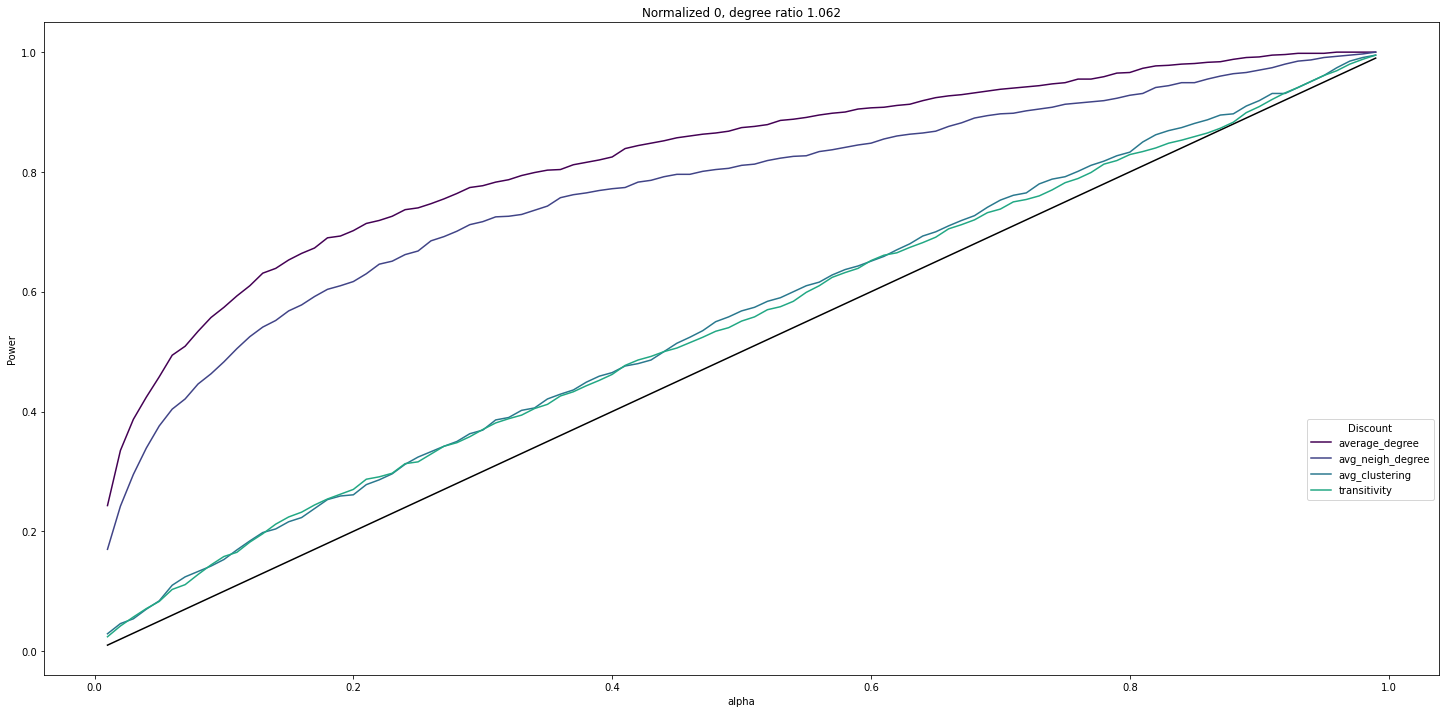

In [28]:
df = GRAPHSTATS
normalize = 0
v = sorted(np.unique(df['ratio_degree']))[0]
n1 = 20
n2 = n1
nr_nodes_1 = 60
nr_nodes_2 = nr_nodes_1

_, ax = plt.subplots(figsize = (25,12))


label = []
#icefire
cmap = get_cmap(sns.color_palette("viridis", as_cmap=True)) # type: matplotlib.colors.ListedColormap
colors = cmap.colors[::int(len(cmap.colors)/(4+1))]  # type: list

ab_line_plotted = False
graph_statistic_plotted = False


tmp = df.loc[(df['ratio_degree'] == v) & (df['n'] == n1) & (df['m'] == n2) & (df['nr_nodes_1'] == nr_nodes_1) & (df['nr_nodes_2'] == nr_nodes_2) ]

x = tmp['alpha']
if len(x)>0:
        ax.plot(x, x, color = 'black')
        ab_line_plotted = True



ax.plot(x, tmp['average_degree'], color =colors[0], label=str(v))
label.append('average_degree')

ax.plot(x, tmp['avg_neigh_degree'], color =colors[1], label=str(v))
label.append('avg_neigh_degree')

ax.plot(x, tmp['avg_clustering'], color =colors[2], label=str(v))
label.append('avg_clustering')

ax.plot(x, tmp['transitivity'], color =colors[3], label=str(v))
label.append('transitivity')



#ax.legend(label)
h, l = ax.get_legend_handles_labels()

ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'Discount', bbox_to_anchor=(1, 0.4))

ax.set_xlabel('alpha')
ax.set_ylabel('Power')
ax.set_title(f'Normalized {normalize}, degree ratio {v}')


plt.show()

In [29]:
GRAPHSTAT_AUC = findAUC(keys = keys, params = [], stats = ['average_degree'], df = GRAPHSTATS )

# WL

Let's see how the WL iterations affect the power

In [30]:
def readfoldertopandaWL(path):
    """
    Read files in a folder and concatenate them into an pandas data frame


    """
    onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    # read and append
    df = []
    cnt = 0
    for file in onlyfiles:
        tmp = pd.read_pickle(os.path.join(path, file))
        ok = file.rsplit("norm", 1)[-1]
        norm = int(re.findall(r'\d+', ok)[0])
        tmp['normalize'] = norm
        df.append(tmp)
        if cnt < 10:
            print(f'norm is {norm}')
            cnt += 1

    return pd.concat(df)

def get_wl_iteration(string_list):
    numbers_list = np.zeros(len(string_list))
    for i, input_string in enumerate(string_list):
        ok = input_string.rsplit("'n_iter'", 1)[-1]
        numbers_list[i] = int(re.findall(r'\d+', ok)[0])
    
    return numbers_list
            

In [31]:
WL = readfoldertopandaWL("../data/BGDegreeLabel/WLsubtree")
WL['wl_itr'] = get_wl_iteration(WL['kernel'])


norm is 0
norm is 0
norm is 0
norm is 0
norm is 0
norm is 1
norm is 1
norm is 1
norm is 1
norm is 1


In [32]:
WL.columns 

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'sinkhorn', 'wl_itr'],
      dtype='object')

In [33]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

WL.loc[WL['nitr'].isna(), 'nitr'] = WL.loc[WL['nitr'].isna(), 'wl_itr']

In [34]:
sorted(np.unique(WL['nr_nodes_1']))

[60]

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


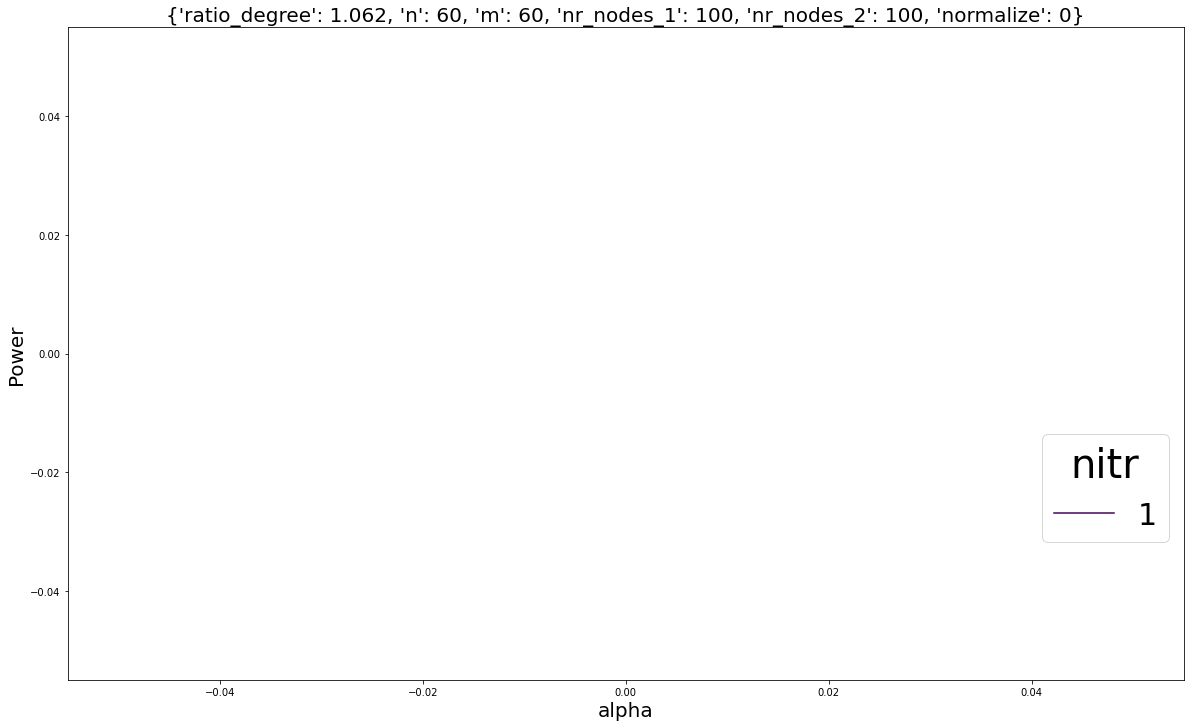

In [87]:
data['WL'] = WL
params_fixed = {'ratio_degree':sorted(np.unique(WL['ratio_degree']))[0],
                'n':60,
                'm':60,
                'nr_nodes_1':100,
                'nr_nodes_2':100,
                #'nitr':4
                'normalize':0
                }


plotVaryingBGDEG(df = WL.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_u", color_name = "viridis")


For each unique row (number of samples, number of nodes, average degree combination), find best parameter combination, by calculating the area under the curve

In [36]:
params_kernel['WL'] = ['nitr', 'normalize']
data_auc['WL'] = findAUC(keys = keys, params = params_kernel['WL'], stats = ['MMD_b', 'MMD_u'], df = WL )

# RW

In [37]:
RW = readfoldertopanda("../data/BGDegreeLabel/RW")
RW.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'type', 'discount', 'sinkhorn', 'r',
       'normalize_adj', 'row_normalize_adj', 'tmax'],
      dtype='object')

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


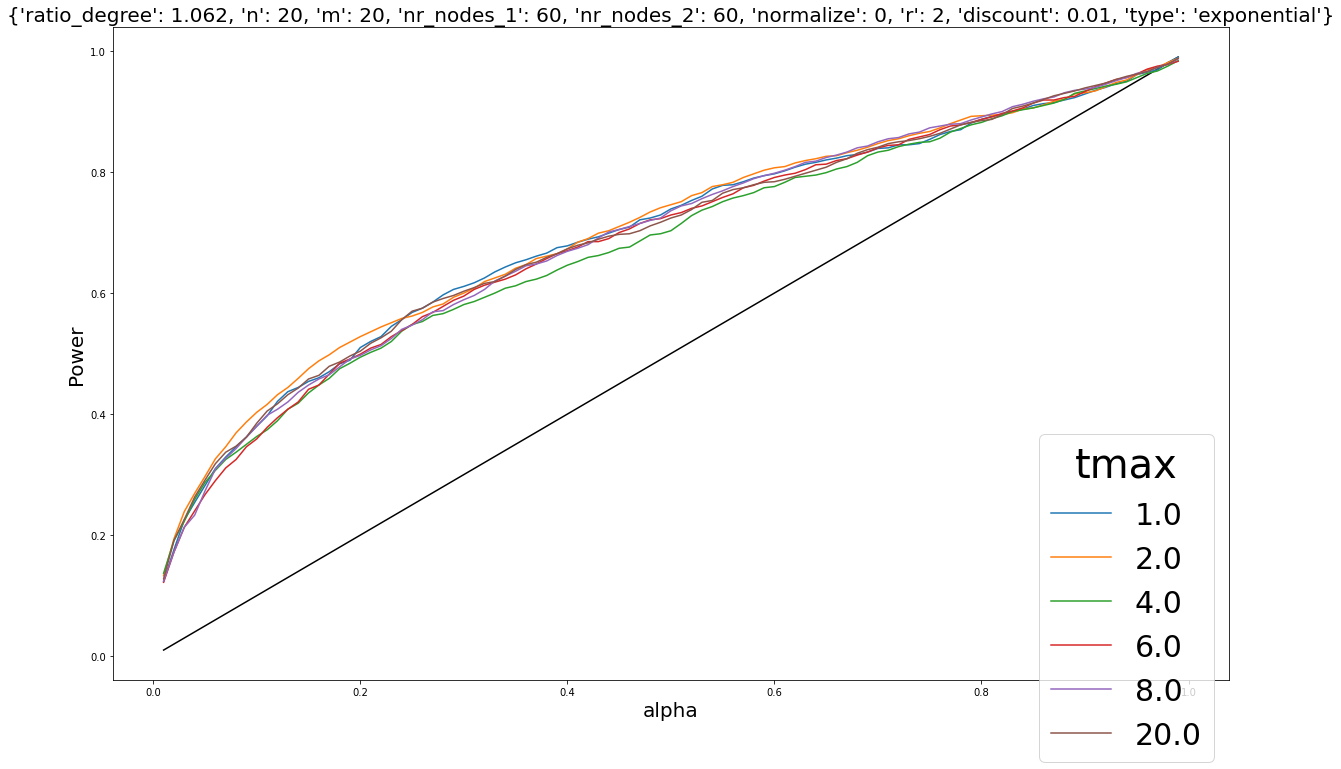

In [38]:
data['RW'] = RW
params_fixed = {'ratio_degree':sorted(np.unique(RW['ratio_degree']))[1],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'r':2,
                'discount':0.01,
                'type':'exponential'
                }

# RW.loc[(RW['tmax'] == 4) | (RW['type'].isin(['ARKL', 'ARKU_plus']))]
plotVaryingBGDEG(df = RW, param_vary_name = "tmax", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "tab10")

In [39]:
params_kernel['RW'] = ['normalize', 'r', 'discount', 'type', 'tmax']
data_auc['RW'] = findAUC(keys = keys, params = params_kernel['RW'], stats = ['MMD_b', 'MMD_u'], df = RW )

## Random walk vs average degree

In [100]:
tmp_gs

,alpha,nr_nodes_1,nr_nodes_2,p_edge_1,p_edge_2,degree_1,degree_2,ratio_p,ratio_degree,n,...,B,N,run_time,average_degree,median_degree,avg_neigh_degree,avg_clustering,transitivity,kernel,normalize
0,0.01,60,60,0.067797,0.072034,4.0,4.25,0.0,1.062,20,...,1000,1000,0:10:05.965456,0.243,0.976,0.170,0.029,0.024,NaN,NaN
1,0.02,60,60,0.067797,0.072034,4.0,4.25,0.0,1.062,20,...,1000,1000,0:10:05.985482,0.335,0.988,0.242,0.046,0.042,NaN,NaN
2,0.03,60,60,0.067797,0.072034,4.0,4.25,0.0,1.062,20,...,1000,1000,0:10:06.000072,0.387,0.989,0.295,0.054,0.057,NaN,NaN
3,0.04,60,60,0.067797,0.072034,4.0,4.25,0.0,1.062,20,...,1000,1000,0:10:06.014783,0.424,0.993,0.339,0.070,0.071,NaN,NaN
4,0.05,60,60,0.067797,0.072034,4.0,4.25,0.0,1.062,20,...,1000,1000,0:10:06.029469,0.458,0.998,0.376,0.084,0.083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.95,60,90,0.067797,0.047753,4.0,4.25,0.0,1.062,20,...,1000,1000,0:11:23.021371,0.986,0.002,0.992,0.991,0.999,GraphStats,0.0
95,0.96,60,90,0.067797,0.047753,4.0,4.25,0.0,1.062,20,...,1000,1000,0:11:23.036775,0.987,0.002,0.992,0.991,0.999,GraphStats,0.0
96,0.97,60,90,0.067797,0.047753,4.0,4.25,0.0,1.062,20,...,1000,1000,0:11:23.052244,0.988,0.002,0.996,0.991,0.999,GraphStats,0.0
97,0.98,60,90,0.067797,0.047753,4.0,4.25,0.0,1.062,20,...,1000,1000,0:11:23.067764,0.989,0.002,0.997,0.996,0.999,GraphStats,0.0


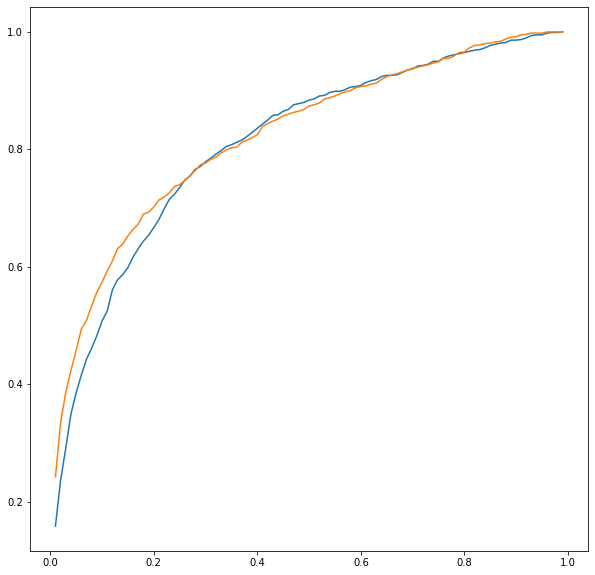

In [101]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
tmp_rw = RW.loc[(RW['tmax'] == 1) & (RW['degree_2'] == 4.25) & (RW['type'] =='p-rw')  & (RW['r'] == 2) & (RW['discount'] == 0.01)]
tmp_gs = GRAPHSTATS.loc[(GRAPHSTATS['degree_2'] == 4.25) & (GRAPHSTATS['n'] == 20) & (GRAPHSTATS['nr_nodes_1'] == 60) & (GRAPHSTATS['nr_nodes_2'] == 60) ]
ax.plot(tmp_rw['alpha'], tmp_rw['MMD_u'])
ax.plot(tmp_gs['alpha'], tmp_gs['average_degree'])

# Shortest Path

In [40]:
SP = readfoldertopandaWL("../data/BGDegreeLabel/SP")

norm is 0
norm is 1
norm is 0
norm is 1
norm is 0
norm is 1
norm is 0
norm is 1
norm is 0
norm is 1


In [41]:
SP.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'sinkhorn'],
      dtype='object')

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


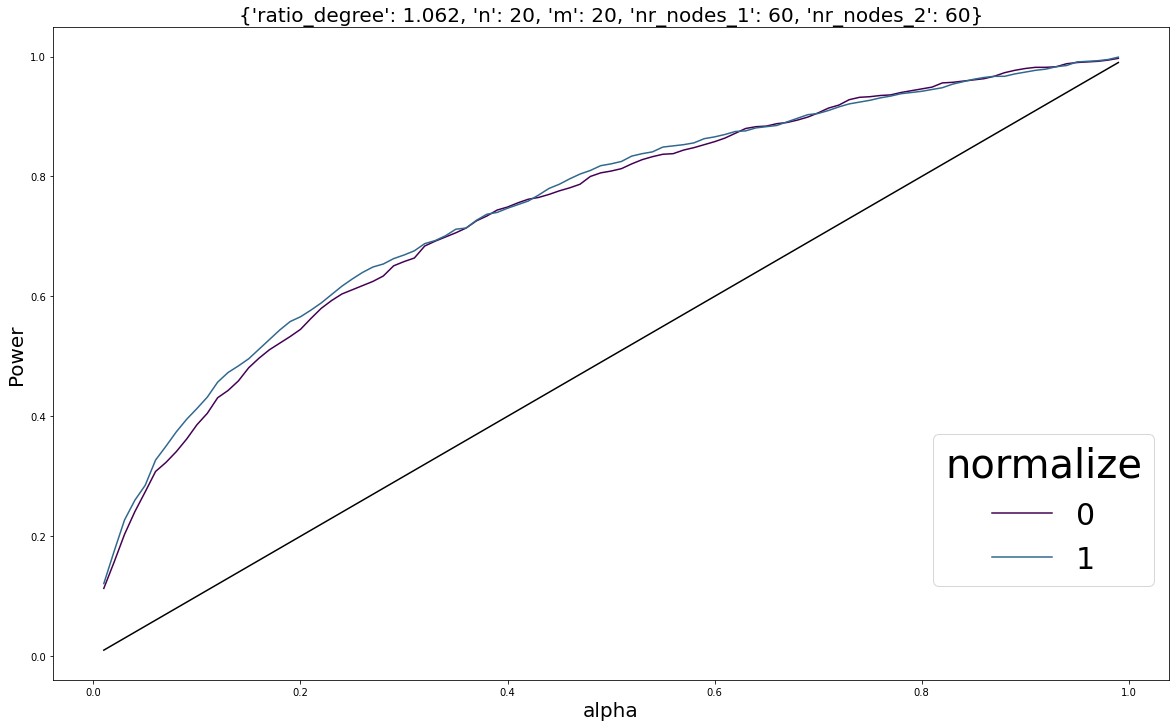

In [42]:
data['SP'] = SP
params_fixed = {'ratio_degree':sorted(np.unique(SP['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60
                #'normalize':1
                }


plotVaryingBGDEG(df = SP.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [43]:
SP.columns


Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'sinkhorn'],
      dtype='object')

In [44]:
params_kernel['SP'] = ['normalize']
data_auc['SP'] = findAUC(keys = keys, params = params_kernel['SP'], stats = ['MMD_b', 'MMD_u'], df = SP )


# WWL

In [45]:
WWL = readfoldertopanda("../data/BGDegreeLabel/WWL")
WWL.columns



Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'discount', 'sinkhorn',
       'wl_itr', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity'],
      dtype='object')

In [46]:
# Because of some changes I created different coLumns for same parameter. I need to put all the information into one parameter

WWL.loc[WWL['nitr'].isna(), 'nitr'] = WWL.loc[WWL['nitr'].isna(), 'wl_itr']



In [47]:
np.unique(WWL['n'])

array([ 10,  20,  60, 100], dtype=int64)

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


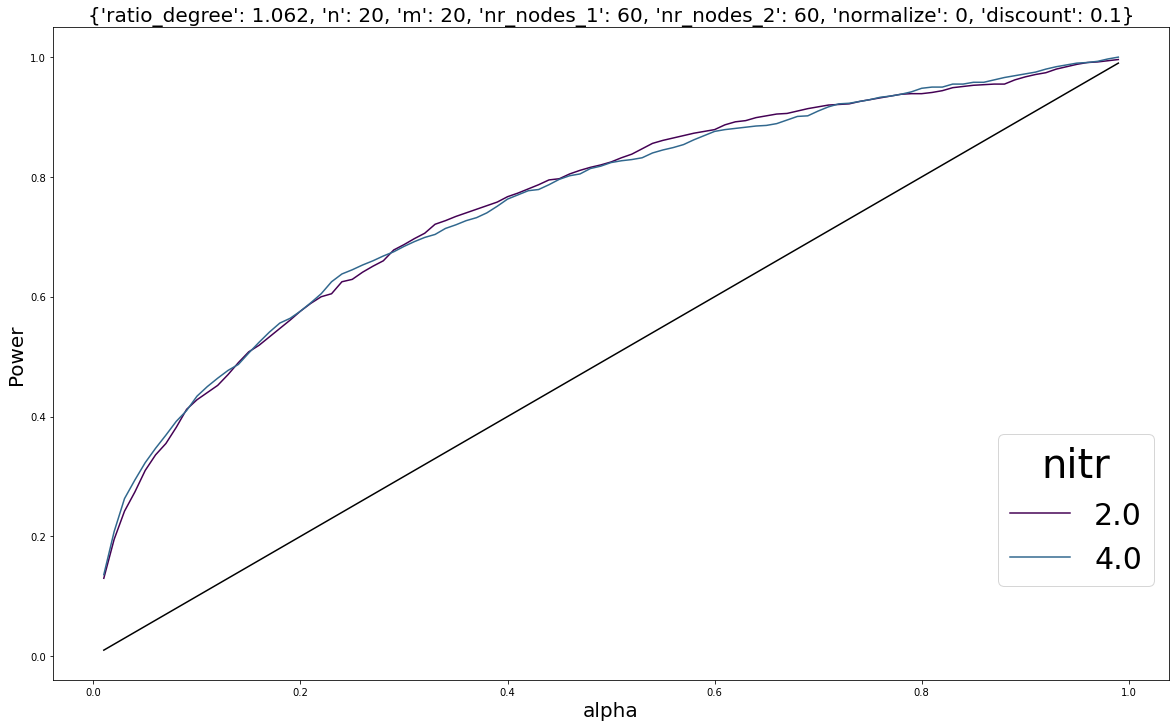

In [48]:
data['WWL'] = WWL
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'discount':0.1
                #'nitr':4
                }

plotVaryingBGDEG(df = WWL.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [49]:
WWL.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'discount', 'sinkhorn',
       'wl_itr', 'average_degree', 'median_degree', 'avg_neigh_degree',
       'avg_clustering', 'transitivity'],
      dtype='object')

In [50]:
params_kernel['WWL'] = ['normalize', 'sinkhorn', 'discount', 'nitr']
data_auc['WWL'] = findAUC(keys = keys, params = params_kernel['WWL'], stats = ['MMD_b', 'MMD_u'], df = WWL )


# Propagation

In [51]:
PROP = readfoldertopanda("../data/BGDegreeLabel/PROP")
PROP.columns

Index(['kernel', 'alpha', 'normalize', 't_max', 'binwidth', 'M_distance',
       'nr_nodes_1', 'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1',
       'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm', 'timestap', 'B', 'N',
       'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree',
       'average_degree', 'median_degree', 'avg_neigh_degree', 'avg_clustering',
       'transitivity', 'with_labels', 'w', 'tmax', 'M', 'sinkhorn'],
      dtype='object')

In [52]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

PROP.loc[PROP['w'].isna(), 'w'] = PROP.loc[PROP['w'].isna(), 'binwidth']
PROP.loc[PROP['tmax'].isna(), 'tmax'] = PROP.loc[PROP['tmax'].isna(), 't_max']
PROP.loc[PROP['M'].isna(), 'M'] = PROP.loc[PROP['M'].isna(), 'M_distance']

In [53]:
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


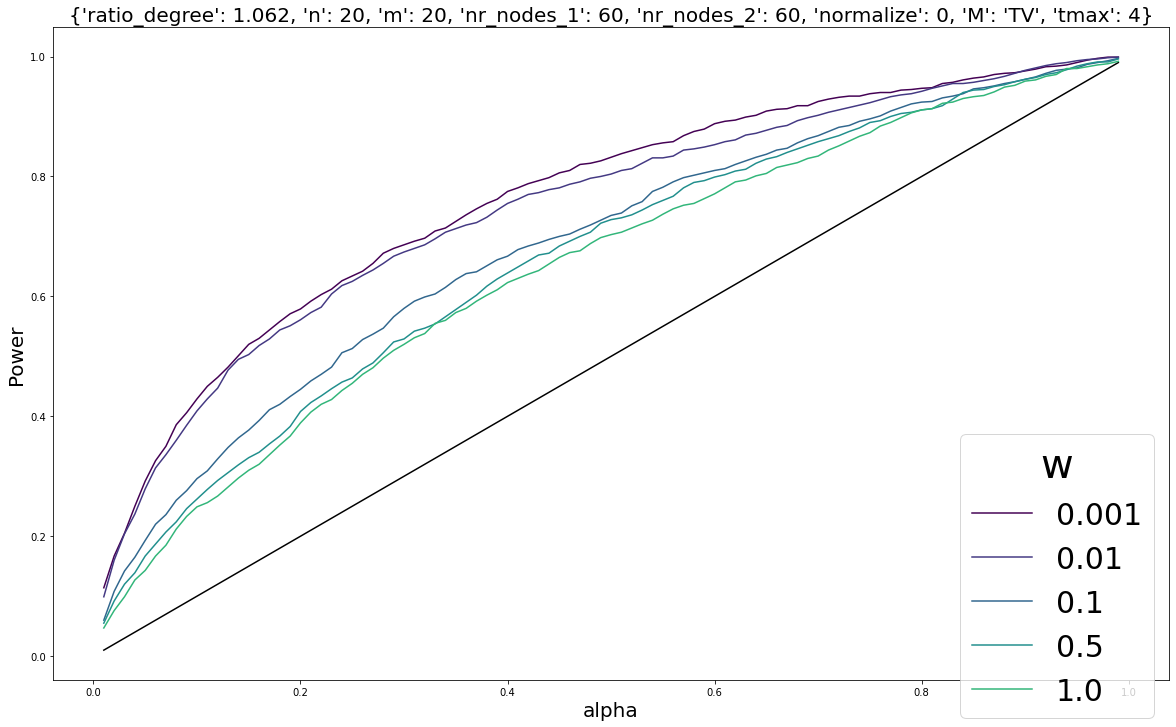

In [54]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['PROP'] = PROP
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'M':'TV',
                #'w':0.01
                'tmax':4
                }

plotVaryingBGDEG(df = PROP.copy(), param_vary_name = "w", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

Will reject more often with lower width

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


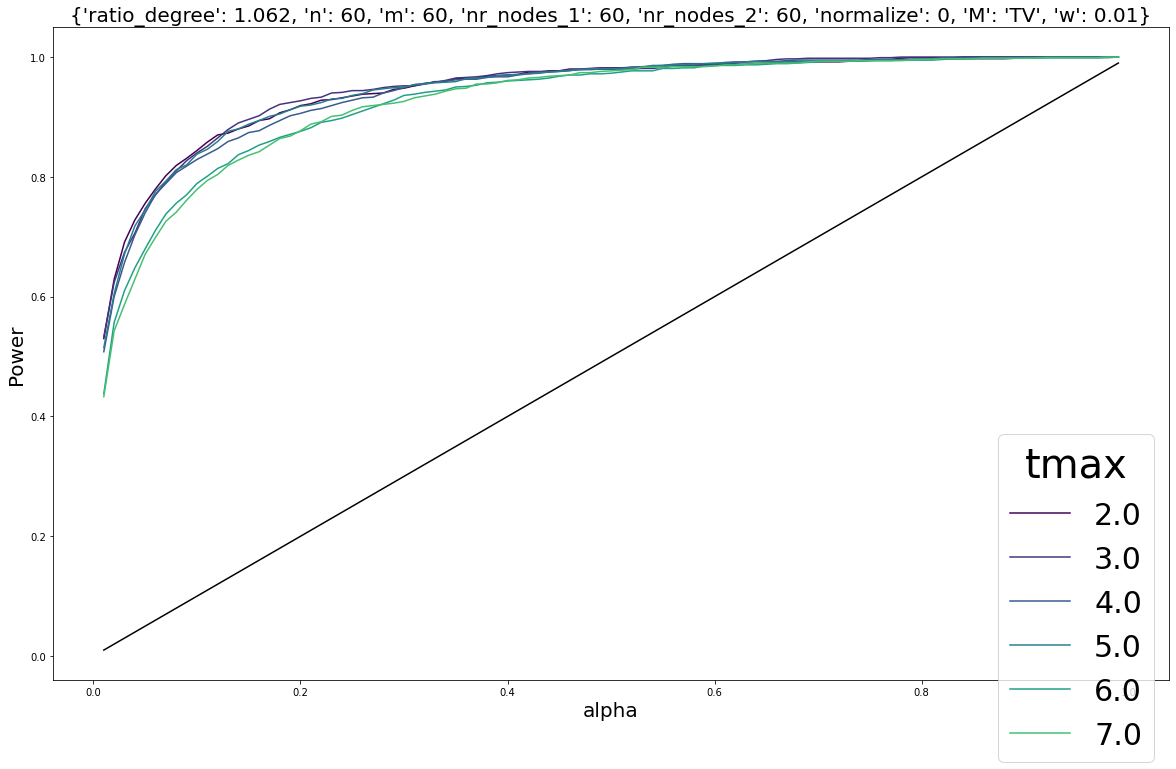

In [55]:

#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':60,
                'm':60,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'M':'TV',
                'w':0.01
                }

plotVaryingBGDEG(df = PROP.copy(), param_vary_name = "tmax", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

tmax does not matter for degree labels

In [56]:
params_kernel['PROP'] = ['normalize', 'tmax', 'w', 'M']
data_auc['PROP'] = findAUC(keys = keys, params = params_kernel['PROP'], stats = ['MMD_b', 'MMD_u'], df = PROP )

# Pyramid

In [57]:
PYRAMID = readfoldertopanda("../data/BGDegreeLabel/PYRAMID")
PYRAMID.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'L', 'dim', 'sinkhorn'],
      dtype='object')

In [58]:
# Because of some changes I created different columns for same parameter. I need to put all the information into one parameter

# PYRAMID.loc[PYRAMID['dim'].isna(), 'dim'] = PYRAMID.loc[PYRAMID['dim'].isna(), 'd']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


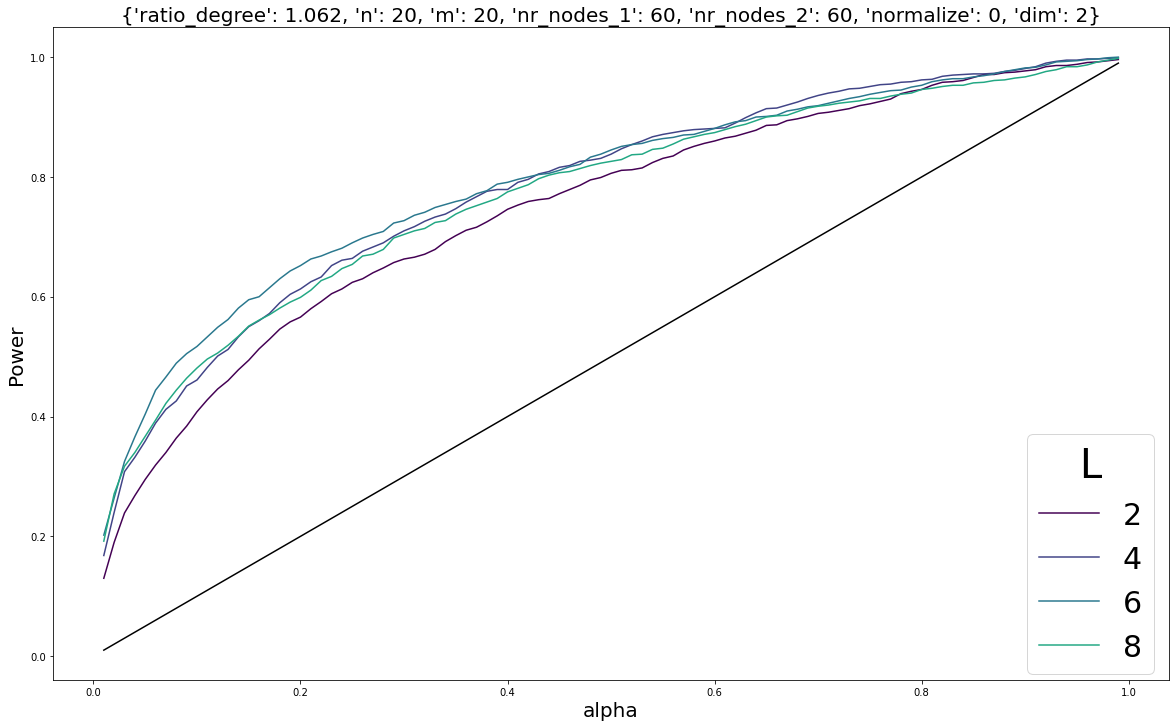

In [59]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['PYRAMID'] = PYRAMID
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'dim':2
                #'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "L", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [60]:
sorted(np.unique(df['ratio_degree']))[0]

1.062

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


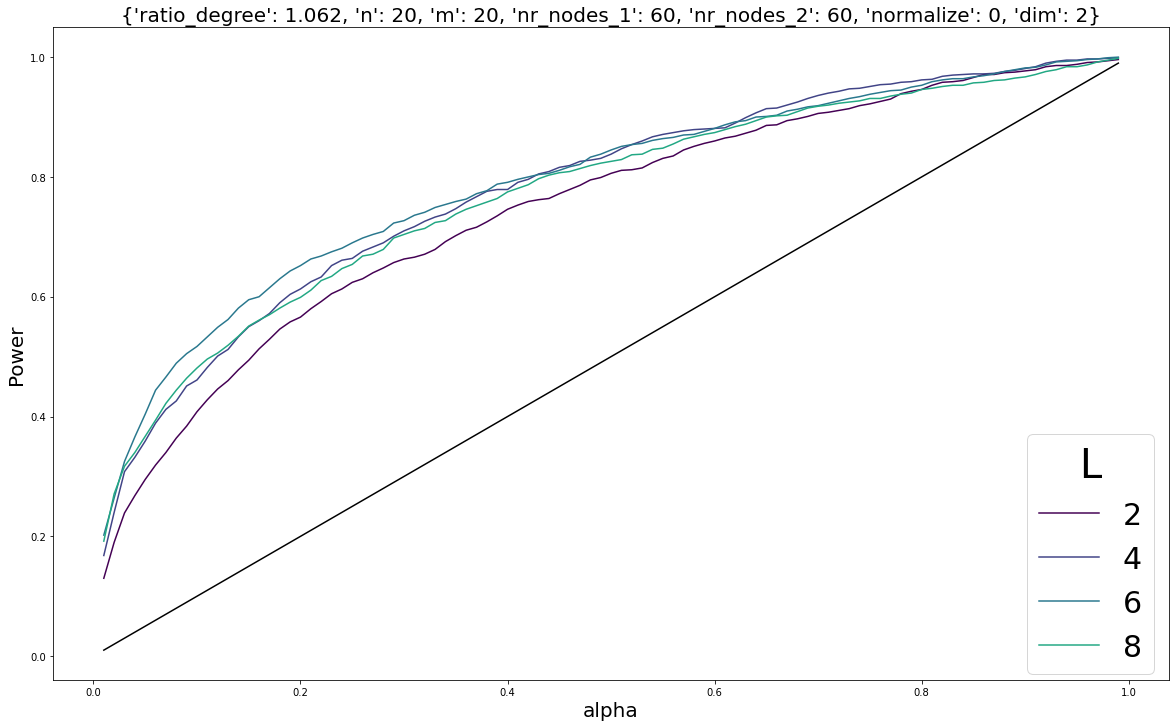

In [61]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'dim':2
                #'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "L", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

Too large L will make the kernel very diagonally dominant.

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


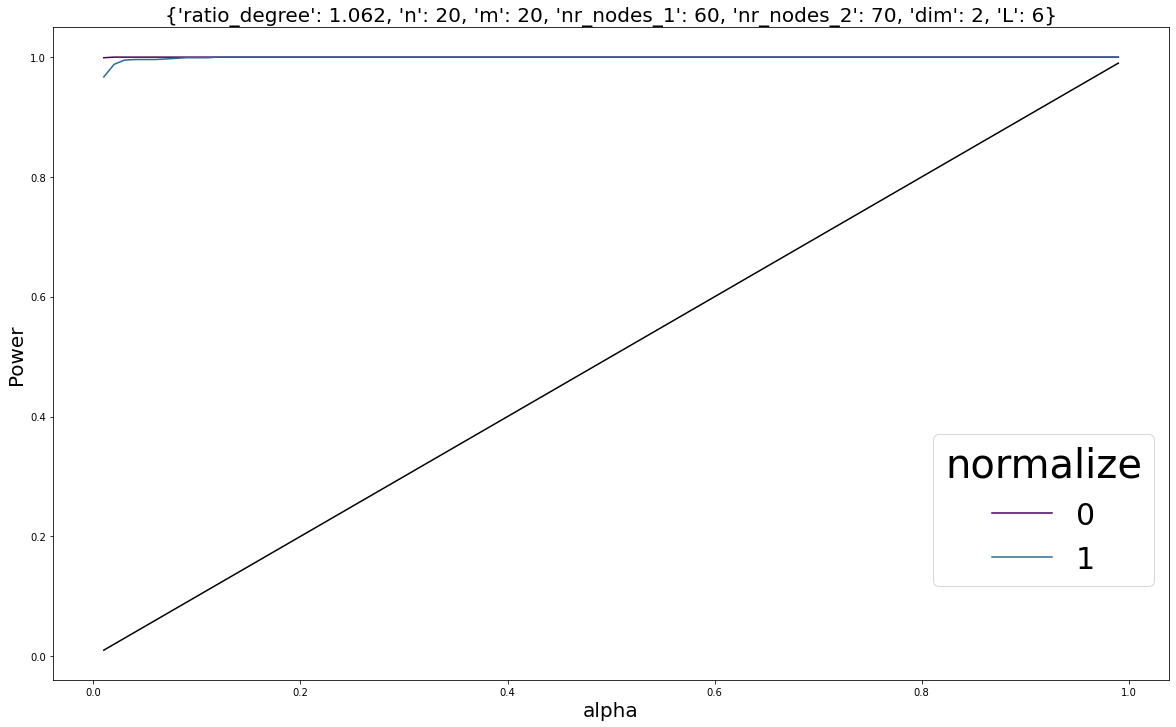

In [62]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70,
                'dim':2,
                'L':6
                }

plotVaryingBGDEG(df = PYRAMID.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [63]:
PYRAMID.columns

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'with_labels', 'L', 'dim', 'sinkhorn'],
      dtype='object')

In [64]:
params_kernel['PYRAMID'] = ['normalize', 'L', 'dim']
data_auc['PYRAMID'] = findAUC(keys = keys, params = params_kernel['PYRAMID'], stats = ['MMD_b', 'MMD_u'], df = PYRAMID )

In [65]:
aaa = data_auc['PYRAMID']

# WLOA

In [66]:
WLOA = readfoldertopanda("../data/BGDegreeLabel/WLOA")
print(WLOA.columns)
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

Index(['kernel', 'alpha', 'normalize', 'nr_nodes_1', 'nr_nodes_2', 'p_edge_1',
       'p_edge_2', 'degree_1', 'degree_2', 'ratio_p', 'ratio_degree', 'n', 'm',
       'timestap', 'B', 'N', 'run_time', 'MMD_b', 'MMD_b_distfree', 'MMD_u',
       'MMD_u_distfree', 'nitr', 'with_labels', 'sinkhorn', 'wl_itr',
       'average_degree', 'median_degree', 'avg_neigh_degree', 'avg_clustering',
       'transitivity'],
      dtype='object')
[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


In [67]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

WLOA.loc[WLOA['nitr'].isna(), 'nitr'] = WLOA.loc[WLOA['nitr'].isna(), 'wl_itr']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


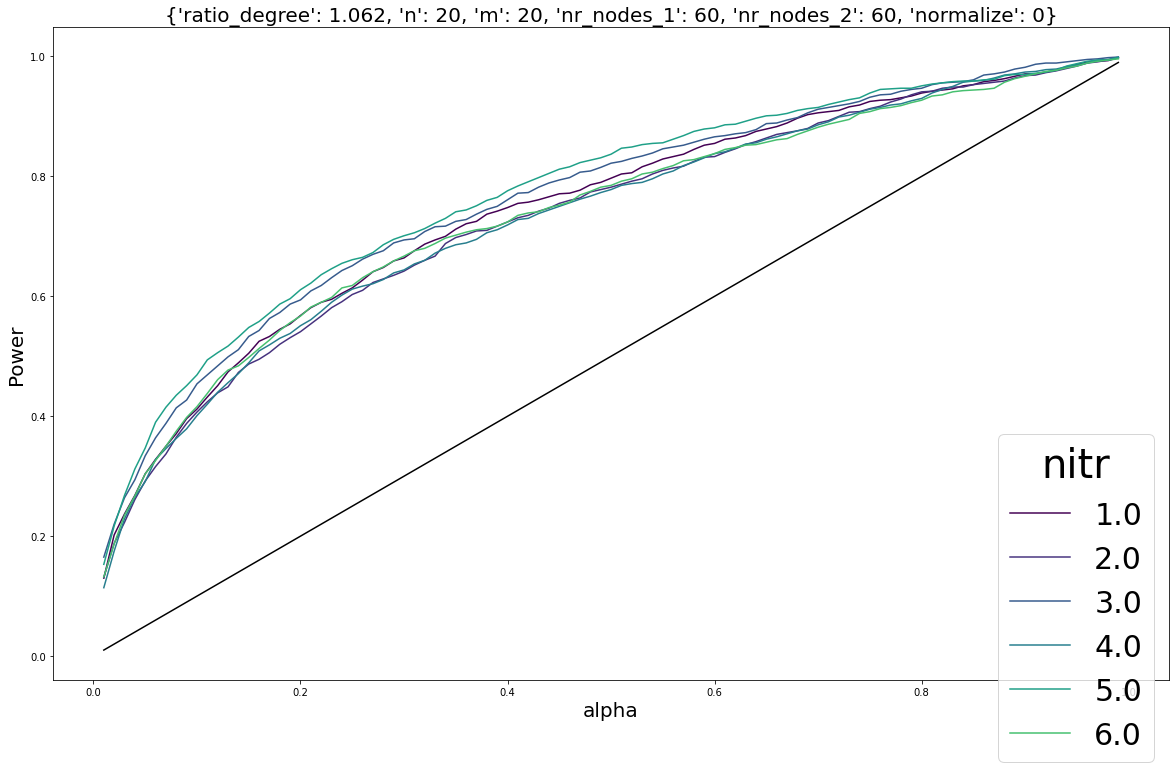

In [68]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['WLOA'] = WLOA
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0
                }

plotVaryingBGDEG(df = WLOA.copy(), param_vary_name = "nitr", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


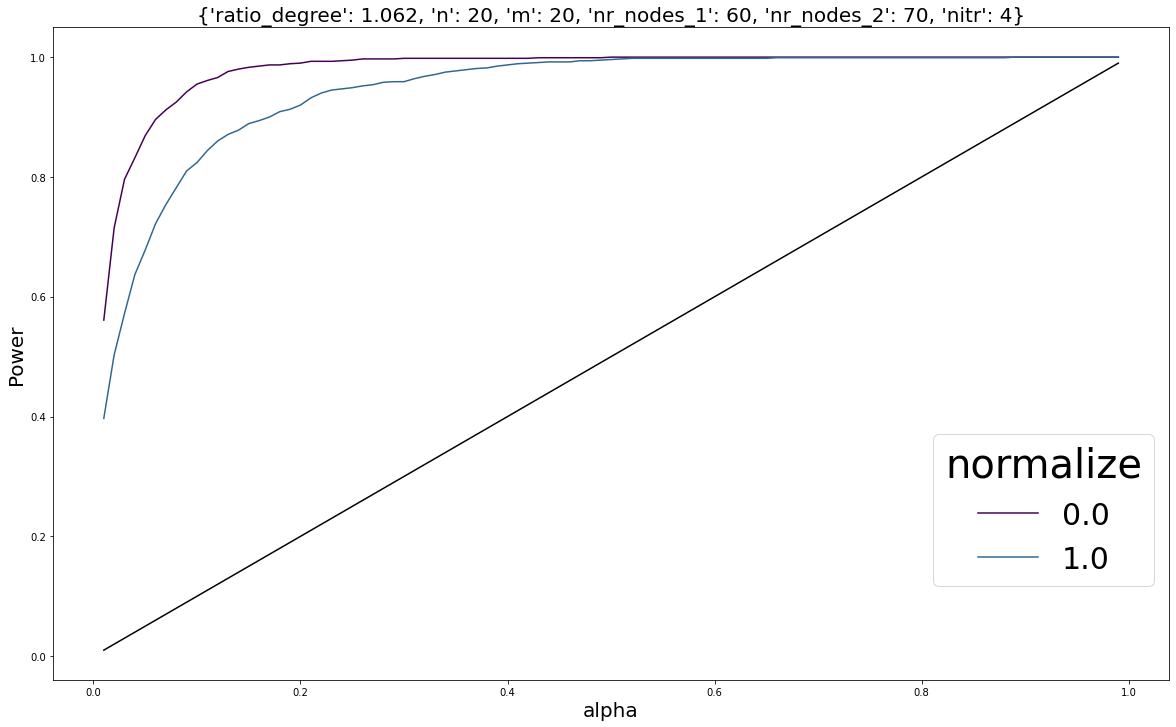

In [69]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':70,
                'nitr':4
                }

plotVaryingBGDEG(df = WLOA.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [70]:
params_kernel['WLOA'] = ['normalize', 'nitr']
data_auc['WLOA'] = findAUC(keys = keys, params = params_kernel['WLOA'], stats = ['MMD_b', 'MMD_u'], df = WLOA )

# VH

In [71]:
VH = readfoldertopanda("../data/BGDegreeLabel/VH")
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


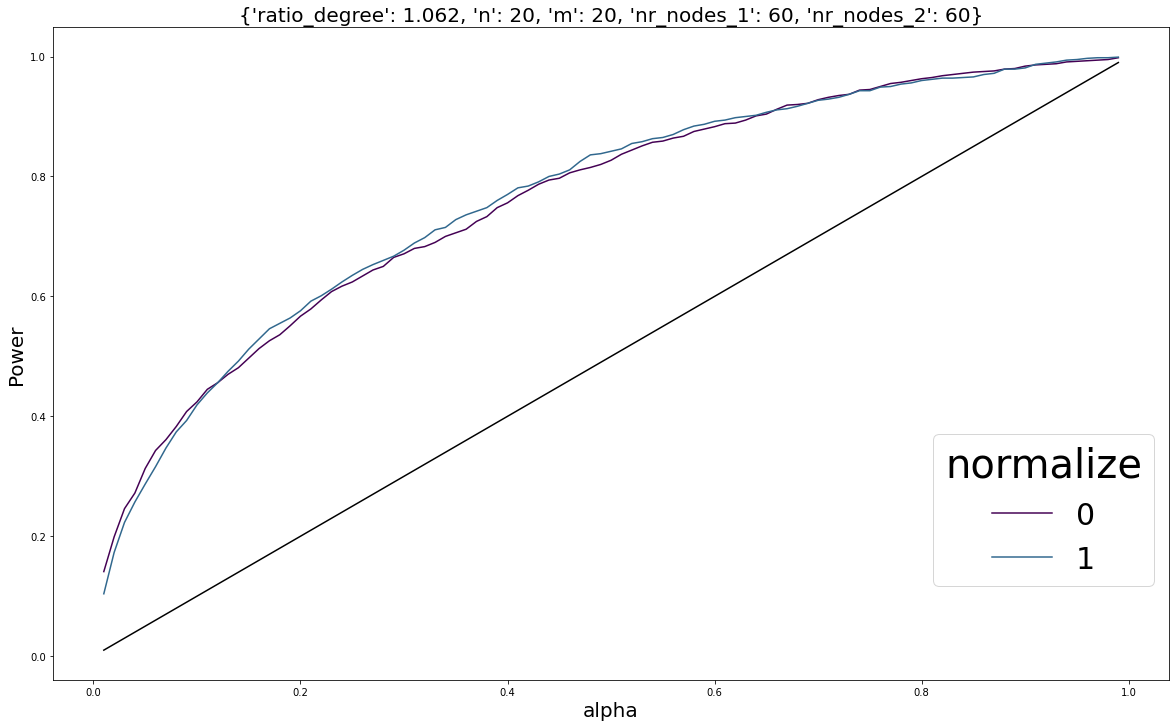

In [72]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['VH'] = VH
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60
                }

plotVaryingBGDEG(df = VH.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [73]:
params_kernel['VH'] = ['normalize']
data_auc['VH'] = findAUC(keys = keys, params = params_kernel['VH'], stats = ['MMD_b', 'MMD_u'], df = VH )

# ODD

In [74]:
ODD = readfoldertopanda("../data/BGDegreeLabel/ODD")
print(ODD.columns)
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

Index(['kernel', 'alpha', 'normalize', 'dag_depth', 'nr_nodes_1', 'nr_nodes_2',
       'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'with_labels', 'dagh',
       'sinkhorn'],
      dtype='object')
[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


In [75]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

ODD.loc[ODD['dagh'].isna(), 'dagh'] = ODD.loc[ODD['dagh'].isna(), 'dag_depth']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


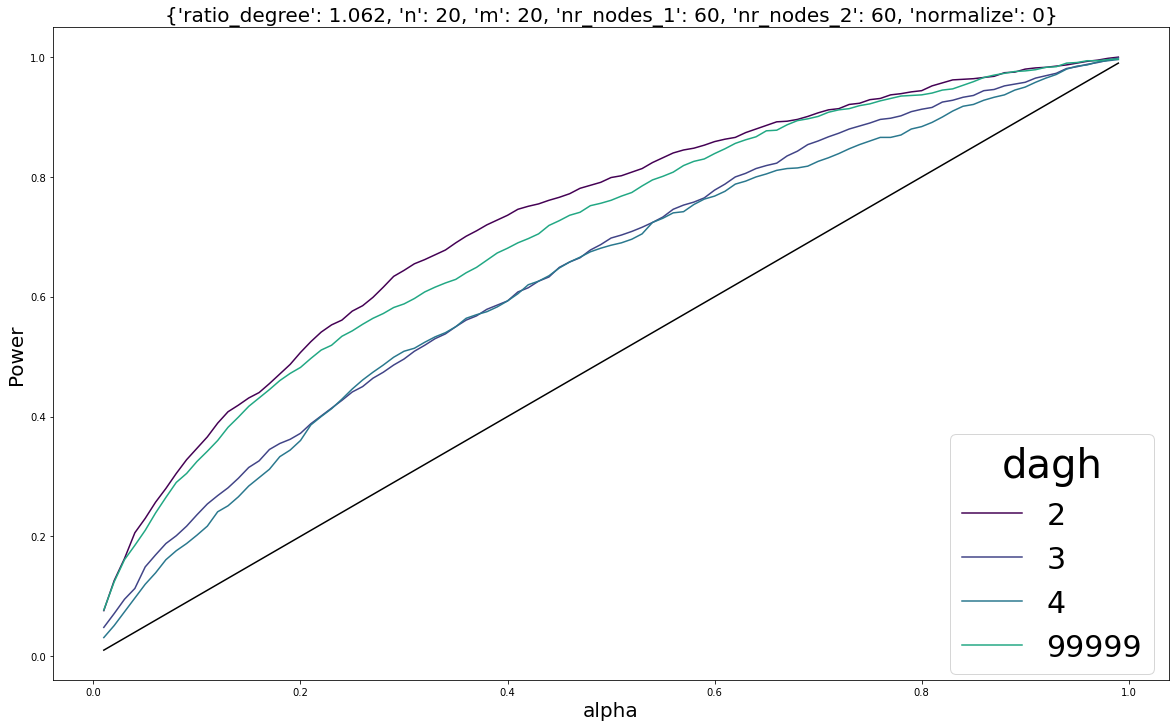

In [76]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['ODD'] = ODD
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0
                }

plotVaryingBGDEG(df = ODD.copy(), param_vary_name = "dagh", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

Seems like the dag_depth should not be too high

In [77]:
params_kernel['ODD'] = ['normalize', 'dagh']
data_auc['ODD'] = findAUC(keys = keys, params = params_kernel['ODD'], stats = ['MMD_b', 'MMD_u'], df = ODD )

# DK

In [78]:
DK = readfoldertopanda("../data/BGDegreeLabel/DK")
print(DK.columns)
print(np.unique(df['n']))
print(np.unique(df['m']))
print(np.unique(df['nr_nodes_1']))
print(np.unique(df['nr_nodes_2']))

Index(['kernel', 'alpha', 'normalize', 'dk_type', 'wl_itr', 'nr_nodes_1',
       'nr_nodes_2', 'p_edge_1', 'p_edge_2', 'degree_1', 'degree_2', 'ratio_p',
       'ratio_degree', 'n', 'm', 'timestap', 'B', 'N', 'run_time', 'MMD_b',
       'MMD_b_distfree', 'MMD_u', 'MMD_u_distfree', 'nitr', 'with_labels',
       'type', 'sinkhorn'],
      dtype='object')
[ 10  20  40  60 100]
[ 10  20  40  60 100]
[20 60 80]
[20 60 65 70 75 80 90]


In [79]:
# Because of some changes I created different coumns for same parameter. I need to put all the information into one parameter

DK.loc[DK['type'].isna(), 'type'] = DK.loc[DK['type'].isna(), 'dk_type']
DK.loc[DK['nitr'].isna(), 'nitr'] = DK.loc[DK['nitr'].isna(), 'wl_itr']


c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


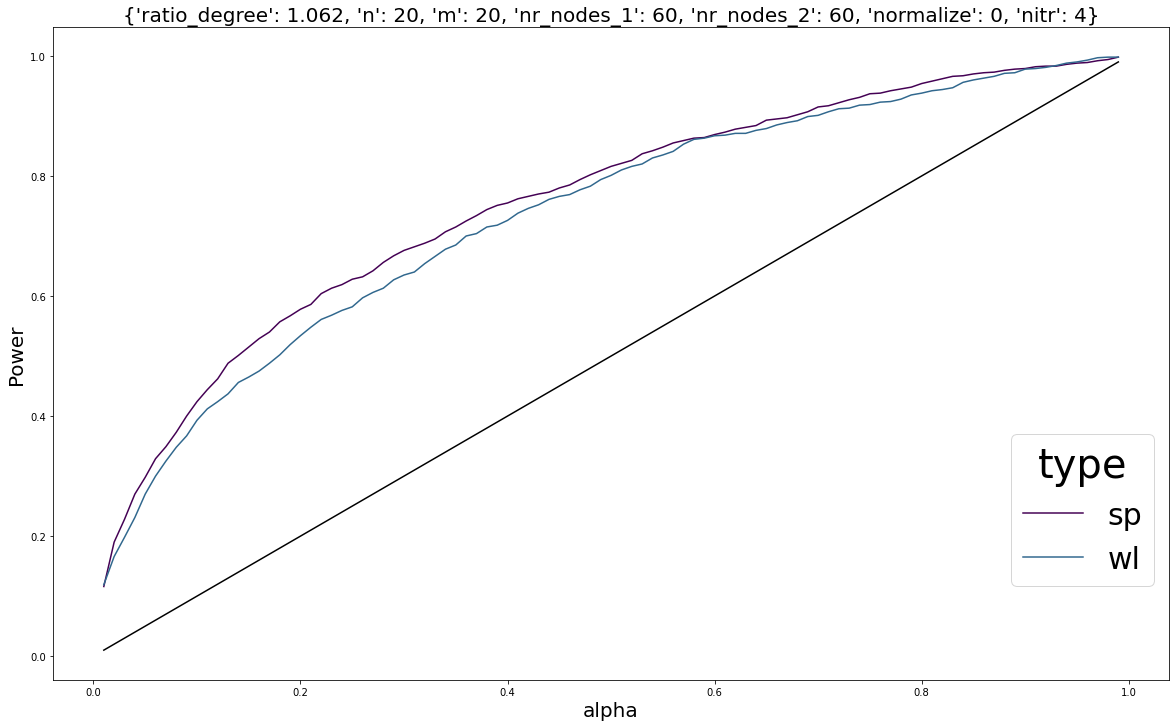

In [80]:
#print(sorted(np.unique(df['ratio_degree']))[0])
data['DK'] = DK
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':60,
                'normalize':0,
                'nitr':4
                }

plotVaryingBGDEG(df = DK.copy(), param_vary_name = "type", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


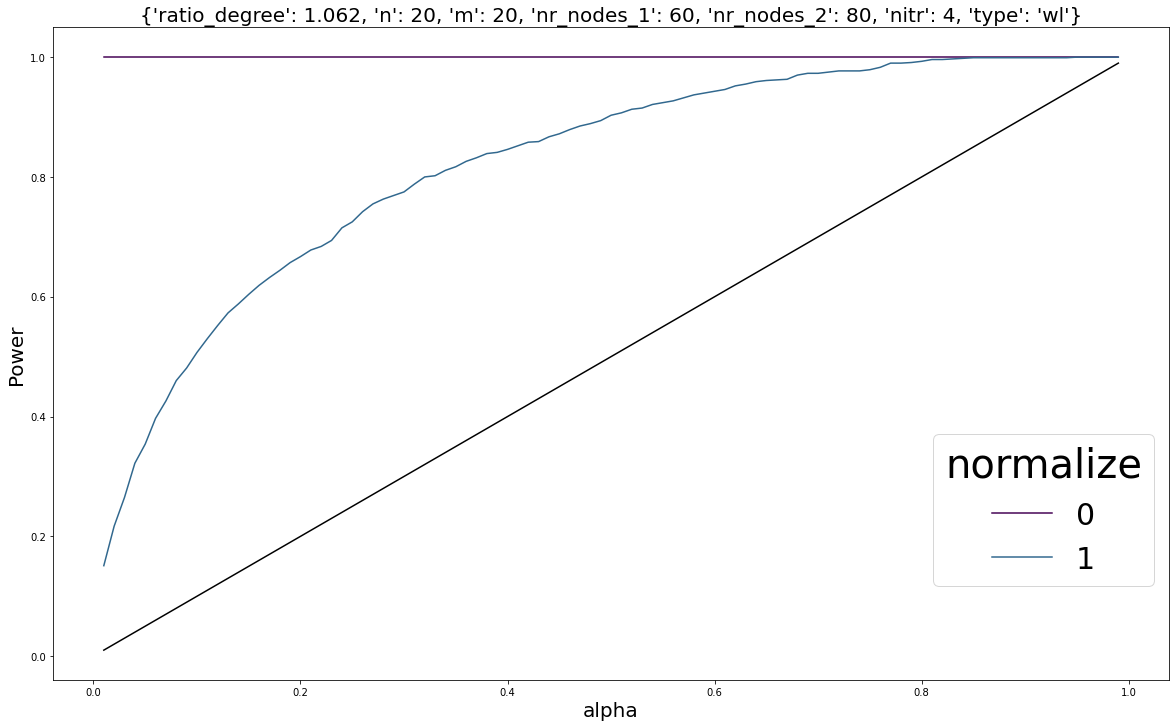

In [81]:
#print(sorted(np.unique(df['ratio_degree']))[0])
params_fixed = {'ratio_degree':sorted(np.unique(df['ratio_degree']))[0],
                'n':20,
                'm':20,
                'nr_nodes_1':60,
                'nr_nodes_2':80,
                'nitr':4,
                'type':'wl'
                }

plotVaryingBGDEG(df = DK.copy(), param_vary_name = "normalize", params_fixed = params_fixed, mmd_stat = "MMD_b", color_name = "viridis")

In [82]:
params_kernel['DK'] = ['normalize', 'type', 'nitr']
data_auc['DK'] = findAUC(keys = keys, params = params_kernel['DK'], stats = ['MMD_b', 'MMD_u'], df = DK )

In [83]:
data_auc

{'WL':     nr_nodes_1  nr_nodes_2  degree_1  degree_2    n    m  nitr  normalize  \
 0           60          60       4.0      4.25  100  100   1.0          0   
 0           60          60       4.0      4.25  100  100   2.0          0   
 0           60          60       4.0      4.25  100  100   4.0          0   
 0           60          60       4.0      4.25  100  100   6.0          0   
 0           60          60       4.0      4.25  100  100   8.0          0   
 ..         ...         ...       ...       ...  ...  ...   ...        ...   
 0           60          90       4.0      4.75   60   60   1.0          1   
 0           60          90       4.0      4.75   60   60   2.0          1   
 0           60          90       4.0      4.75   60   60   4.0          1   
 0           60          90       4.0      4.75   60   60   6.0          1   
 0           60          90       4.0      4.75   60   60   8.0          1   
 
     MMD_b_auc  MMD_u_auc  
 0    0.973420   0.973420  


# Comparing all with best params

In [84]:

key_pair = pd.DataFrame({'nr_nodes_1':60, 
            'nr_nodes_2':60, 
            'degree_1':4,
            'degree_2':4.25, 
            'n':20, 
            'm':20}, index = [0])

stat = 'MMD_u_auc'
stat_plot = 'MMD_u'

best = []

for k,v in data.items():

    k_data_max = data_auc[k].reset_index().merge(key_pair, on = keys)
    if k == 'PYRAMID':
        print(k_data_max)
        k_data_max = k_data_max.loc[k_data_max['L'] > 2]

    k_data_max = data_auc[k].reset_index().merge(key_pair, on = keys)

    if key_pair['nr_nodes_1'].iloc[0] != key_pair['nr_nodes_2'].iloc[0]:
        k_data_max = k_data_max[(k_data_max['normalize'] != 0)]
        k_data_max = k_data_max[k_data_max.groupby(keys)[stat].transform(max) == k_data_max[stat]].iloc[[0]]
        tmp_data = v[(v['normalize'] != 0)].reset_index().merge(k_data_max, on = keys + params_kernel[k])
    else:
        k_data_max = k_data_max[k_data_max.groupby(keys)[stat].transform(max) == k_data_max[stat]].iloc[[0]]
        tmp_data = v.reset_index().merge(k_data_max, on = keys + params_kernel[k])

    tmp_data['kernel_name'] = k
    best.append(tmp_data)


graph_stat = GRAPHSTATS.reset_index().merge(key_pair, on = keys)



    index  nr_nodes_1  nr_nodes_2  degree_1  degree_2   n   m  normalize  L  \
0       0          60          60       4.0      4.25  20  20          0  2   
1       0          60          60       4.0      4.25  20  20          0  2   
2       0          60          60       4.0      4.25  20  20          0  2   
3       0          60          60       4.0      4.25  20  20          0  2   
4       0          60          60       4.0      4.25  20  20          0  4   
5       0          60          60       4.0      4.25  20  20          0  4   
6       0          60          60       4.0      4.25  20  20          0  4   
7       0          60          60       4.0      4.25  20  20          0  4   
8       0          60          60       4.0      4.25  20  20          0  6   
9       0          60          60       4.0      4.25  20  20          0  6   
10      0          60          60       4.0      4.25  20  20          0  6   
11      0          60          60       4.0      4.2

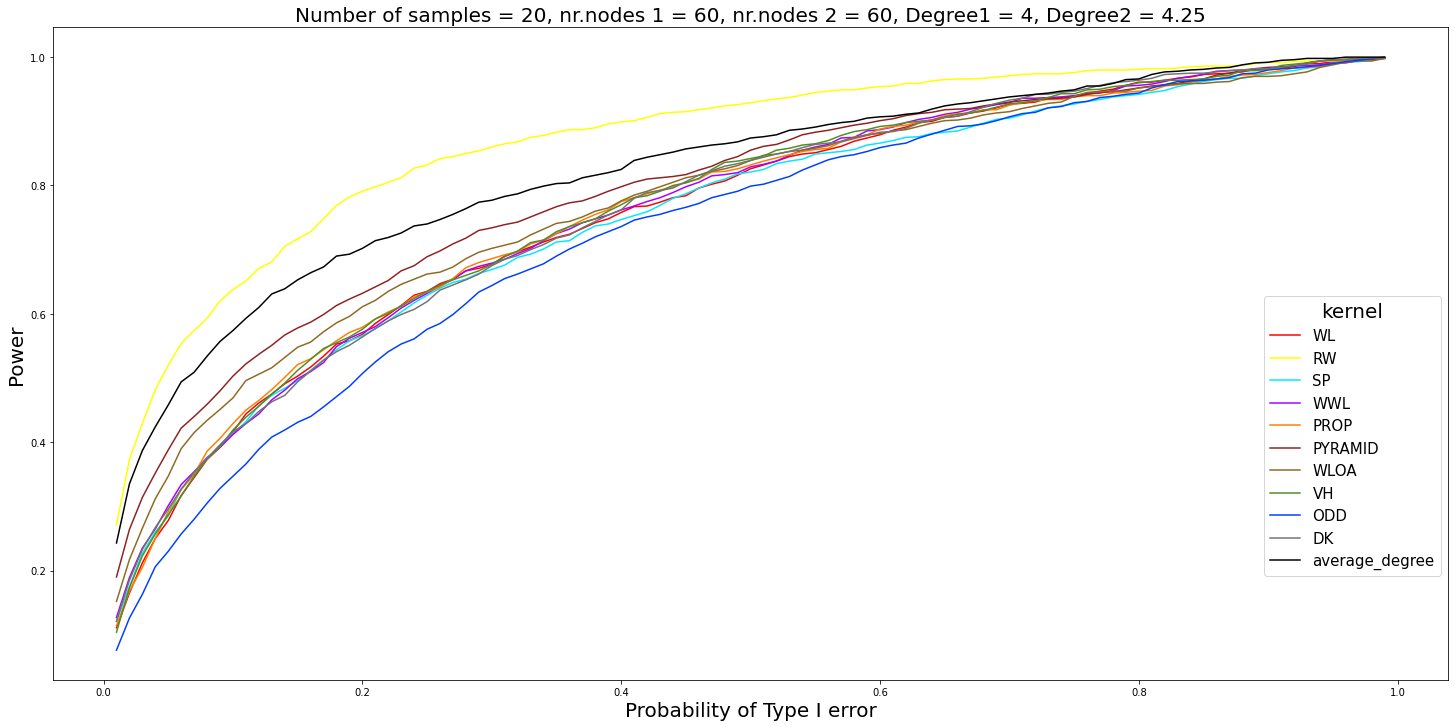

In [86]:
_, ax = plt.subplots(figsize = (25,12))


label = []
#icefire
#cmap = get_cmap(sns.color_palette("viridis", as_cmap=True)) # type: matplotlib.colors.ListedColormap
colors = ['#FF0000', '#FFFF00', '#00EAFF', '#AA00FF', '#FF7F00', '#8F2323', '#8F6A23', '#4F8F23', '#0040FF', '#737373', '#23628F', '#000000']# cmap.colors[::int(len(cmap.colors)/(7+1))]  # type: list

for i,row in enumerate(best):
    ax.plot(row['alpha'], row[stat_plot], color =colors[i], label=str(row['kernel_name'].iloc[0]))
    label.append(str(row['kernel_name'].iloc[0]))


ax.plot(graph_stat['alpha'], graph_stat['average_degree'], color =colors[len(best)+1], label='average_degree')
label.append('average_degree')



h, l = ax.get_legend_handles_labels()


ax.set
ax.legend(handles=h, labels=label, 
        handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)}, title = 'kernel', bbox_to_anchor=(1, 0.6), fontsize = 15, title_fontsize=20)

ax.set_xlabel('Probability of Type I error', fontsize = 20)
ax.set_ylabel('Power', fontsize = 20)
ax.set_title(f'Number of samples = {key_pair["n"].iloc[0]}, nr.nodes 1 = {key_pair["nr_nodes_1"].iloc[0]}, nr.nodes 2 = {key_pair["nr_nodes_2"].iloc[0]}, Degree1 = {key_pair["degree_1"].iloc[0]}, Degree2 = {key_pair["degree_2"].iloc[0]}', fontsize = 20)


plt.show()

In [135]:
with open('../data/bgdeg_data_auc.pkl', 'wb') as handle:
    pickle.dump(data_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)
